In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2
from scipy.interpolate import interpn
from tqdm import tqdm

/home/aramesh/anaconda3/envs/comp-photo/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# load images
lamp_amb = './data/lamp/lamp_ambient.tif'
lamp_flash = './data/lamp/lamp_flash.tif'

lamp_amb = cv2.imread(lamp_amb,-1)[:,:,::-1]
lamp_flash = cv2.imread(lamp_flash,-1)[:,:,::-1]

# normalize to 0-1
lamp_amb_norm = (lamp_amb - np.min(lamp_amb)) / (np.max(lamp_amb) - np.min(lamp_amb))
lamp_flash_norm = (lamp_flash - np.min(lamp_flash)) / (np.max(lamp_flash) - np.min(lamp_flash))


In [3]:
def bilateral_filtering(img1, img2, i_j, sigma_r, sigma_s, kernel_size=[0,0]) :
    
    J_j_list = []
    
    for j in tqdm(range(NB_segments+1)):
        G_j = (1/(sigma_r * np.sqrt(2 * np.pi))) * np.exp((-1/(2 * sigma_r**2)) * (img2-i_j[j])**2 )
        K_j = cv2.GaussianBlur(G_j, kernel_size, sigmaX=sigma_s, sigmaY=sigma_s) # normalization factor. 
        H_j = np.multiply(G_j,img1)
        H_star_j = cv2.GaussianBlur(H_j,kernel_size, sigmaX=sigma_s, sigmaY=sigma_s)
        J_j = H_star_j / K_j
        J_j[K_j == 0] = 1 # to tackle cases where den is zero.
        J_j_list.append(J_j)
    
    J_j_list = np.array(J_j_list)
    points_rows =  np.arange(img1.shape[0])
    points_cols =  np.arange(img1.shape[1])
    pts_needed = []
    for i in range(img1.shape[0]) : 
        for j in range(img1.shape[1]) : 
            pts_needed.append([img1[i,j], i, j])
            
    J = interpn([i_j, points_rows, points_cols], J_j_list, pts_needed)
    J = J.reshape(img1.shape[0], img1.shape[1])
    
    return J

100%|███████████████████████████████████████████| 22/22 [00:03<00:00,  5.53it/s]


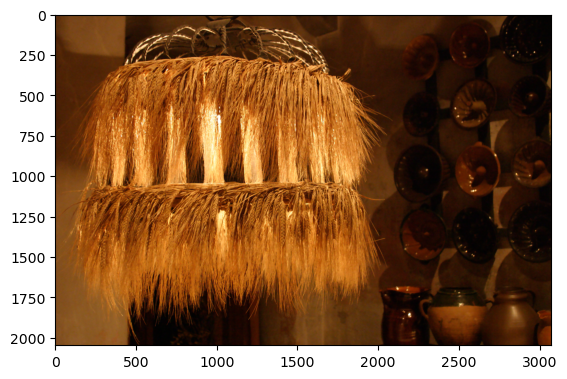

In [4]:
# setting hyper params for bilateral filtering
lmda = 0.01
sigma_r = 0.05
sigma_s = 40
minI = np.min(lamp_amb_norm) - lmda
maxI = np.max(lamp_amb_norm) + lmda
NB_segments = np.ceil((maxI - minI)/sigma_r).astype('int')
i_j = [minI + j * (maxI - minI)/NB_segments for j in range(NB_segments+1)]
kernel_size = [11,11]

J_r = bilateral_filtering(lamp_amb_norm[:,:,0], lamp_amb_norm[:,:,0], i_j, sigma_r, sigma_s,kernel_size)
J_g = bilateral_filtering(lamp_amb_norm[:,:,1], lamp_amb_norm[:,:,1], i_j, sigma_r, sigma_s,kernel_size)
J_b = bilateral_filtering(lamp_amb_norm[:,:,2], lamp_amb_norm[:,:,2], i_j, sigma_r, sigma_s,kernel_size)
J = np.concatenate((np.expand_dims(J_r,-1),np.stack((J_g,J_b),-1)),-1)
plt.imsave('outputs/J_sr_{}_ss_{}_ks_{}_Abase.png'.format(sigma_r, sigma_s, kernel_size[0]), np.clip(J, 0,1))
plt.imshow(np.clip(J, 0,1))
plt.show()

# plt.imsave('outputs_report/J_sr_{}_ss_{}_ks_{}_Abase_change.png'.format(sigma_r, sigma_s, kernel_size[0]), np.clip((lamp_amb_norm-J)*100, 0,1))
# plt.imshow(np.clip((lamp_amb_norm-J)*100, 0,1))
# plt.show()

A_base = J.copy()

# cv2bf = np.clip(cv2.bilateralFilter(lamp_amb_norm.astype('float32'), d=20, sigmaColor=0.05, sigmaSpace=40),0,1)
# plt.imshow(cv2bf)
# plt.imsave('outputs/cv2bf_sr_{}_ss_{}_ks_{}.png'.format(0.05, 40, 20), cv2bf)

100%|███████████████████████████████████████████| 22/22 [00:03<00:00,  7.18it/s]


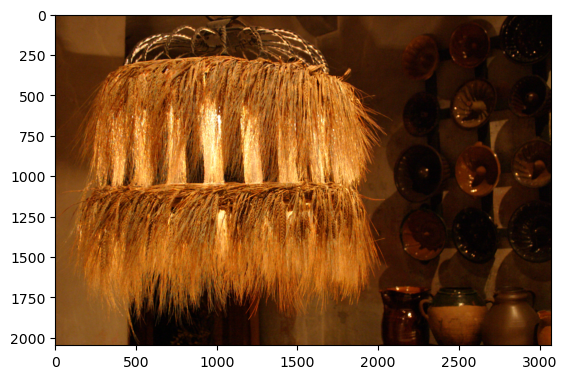

In [5]:
lmda = 0.01
sigma_r = 0.05
sigma_s = 100
minI = np.min(lamp_flash_norm) - lmda
maxI = np.max(lamp_flash_norm) + lmda
NB_segments = np.ceil((maxI - minI)/sigma_r).astype('int')
i_j = [minI + j * (maxI - minI)/(NB_segments) for j in range(NB_segments+1)]
kernel_size = [5,5]

J_r = bilateral_filtering(lamp_amb_norm[:,:,0], lamp_flash_norm[:,:,0], i_j, sigma_r, sigma_s,kernel_size)
J_g = bilateral_filtering(lamp_amb_norm[:,:,1], lamp_flash_norm[:,:,1], i_j, sigma_r, sigma_s,kernel_size)
J_b = bilateral_filtering(lamp_amb_norm[:,:,2], lamp_flash_norm[:,:,2], i_j, sigma_r, sigma_s,kernel_size)
J = np.concatenate((np.expand_dims(J_r,-1),np.stack((J_g,J_b),-1)),-1)
plt.imsave('outputs/J_sr_{}_ss_{}_ks_{}_ANr.png'.format(sigma_r, sigma_s, kernel_size[0]), np.clip(J, 0,1))
plt.imshow(np.clip(J, 0,1))
plt.show()

# plt.imsave('outputs/outputs_report_part1/J_sr_{}_ss_{}_ks_{}_ANr_change.png'.format(sigma_r, sigma_s, kernel_size[0]), np.clip((lamp_amb_norm-J)*100, 0,1))
# plt.imshow(np.clip(lamp_amb_norm-J, 0,1))
# plt.show()

A_NR = J.copy()

100%|███████████████████████████████████████████| 22/22 [00:04<00:00,  5.49it/s]


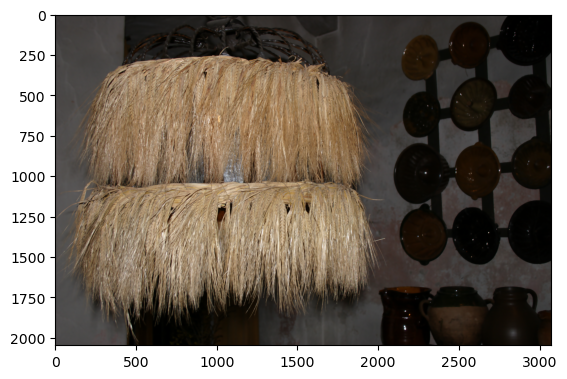

In [6]:
# Calculate Fbase
lmda = 0.01
sigma_r = 0.05
sigma_s = 40
minI = np.min(lamp_flash_norm) - lmda
maxI = np.max(lamp_flash_norm) + lmda
NB_segments = np.ceil((maxI - minI)/sigma_r).astype('int')
i_j = [minI + j * (maxI - minI)/NB_segments for j in range(NB_segments+1)]
kernel_size = [11,11]

J_r = bilateral_filtering(lamp_flash_norm[:,:,0], lamp_flash_norm[:,:,0], i_j, sigma_r, sigma_s,kernel_size)
J_g = bilateral_filtering(lamp_flash_norm[:,:,1], lamp_flash_norm[:,:,1], i_j, sigma_r, sigma_s,kernel_size)
J_b = bilateral_filtering(lamp_flash_norm[:,:,2], lamp_flash_norm[:,:,2], i_j, sigma_r, sigma_s,kernel_size)
J = np.concatenate((np.expand_dims(J_r,-1),np.stack((J_g,J_b),-1)),-1)
plt.imsave('outputs/J_sr_{}_ss_{}_ks_{}_Fbase.png'.format(sigma_r, sigma_s, kernel_size[0]), np.clip(J, 0,1))
plt.imshow(np.clip(J, 0,1))
plt.show()

# plt.imsave('outputs/outputs_report_part1/J_sr_{}_ss_{}_ks_{}_Fbase_change.png'.format(sigma_r, sigma_s, kernel_size[0]), np.clip((lamp_flash_norm-J)*100, 0,1))
# plt.imshow(np.clip((lamp_flash_norm-J)*100, 0,1))
# plt.show()

F_base = J.copy()

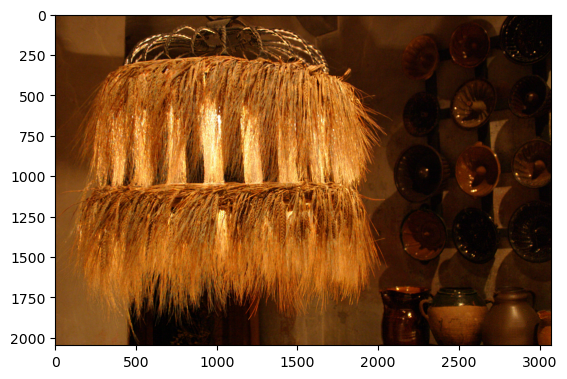

In [7]:
# Apply detail transfer
eps = 0.001
A_detail = A_NR * (lamp_flash_norm + eps) / (F_base + eps)
plt.imsave('outputs/J_sr_{}_ss_{}_ks_{}_eps_{}_Adetail.png'.format(sigma_r, sigma_s, kernel_size[0], eps), np.clip(A_detail, 0,1))
plt.imshow(np.clip(A_detail, 0,1))

# plt.imsave('outputs/outputs_report_part1/J_sr_{}_ss_{}_ks_{}_eps_{}_Adetail_change.png'.format(sigma_r, sigma_s, kernel_size[0], eps), np.clip((lamp_amb_norm-A_detail)*100, 0,1))
# plt.imshow(np.clip((lamp_amb_norm-A_detail)*100, 0,1))
# plt.show()

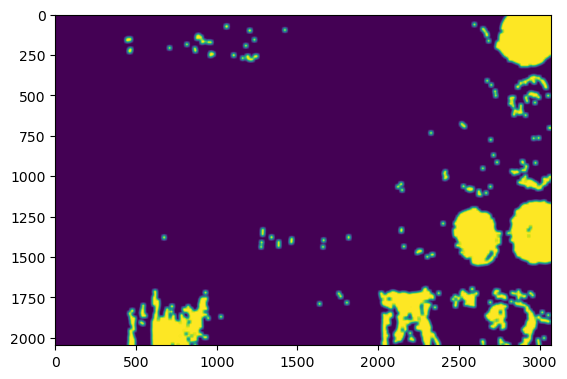

In [8]:
# Computing mask for shadows and specularities

# linearizing images

@np.vectorize
def linearize_image(C_nonlinear) : 
    
    if C_nonlinear <= 0.0404482 : 
        return C_nonlinear / 12.92
    else : 
        out_num = ( C_nonlinear + 0.055 ) ** 2.4
        out_den = 1.055 ** 2.4
        
        return out_num / out_den

lamp_amb_norm_lin = linearize_image(lamp_amb_norm)
lamp_flash_norm_lin = linearize_image(lamp_flash_norm)

#iso correction
# flash image iso-200
# amb image iso-1600
# assuming shutter speed same for both
lamp_amb_norm_lin = lamp_amb_norm_lin * (200/1600)

shadow_threshold = 0.0005
speckle_thershold = 0.9

# luminance_amb = lamp_amb_norm_lin[:,:,0] * 0.2126 + lamp_amb_norm_lin[:,:,1] * 0.7152 + lamp_amb_norm_lin[:,:,2] * 0.0722  
# luminance_flash = lamp_flash_norm_lin[:,:,0] * 0.2126 + lamp_flash_norm_lin[:,:,1] * 0.7152 + lamp_flash_norm_lin[:,:,2] * 0.0722

luminance_amb = cv2.cvtColor(lamp_amb_norm_lin[:,:,::-1].astype('float32'), cv2.COLOR_BGR2YCR_CB)[:,:,0]
luminance_flash = cv2.cvtColor(lamp_flash_norm_lin[:,:,::-1].astype('float32'), cv2.COLOR_BGR2YCR_CB)[:,:,0]

shadow_map = np.zeros(luminance_amb.shape)
shadow_map[np.abs(luminance_flash - luminance_amb) <= shadow_threshold] = 1

speckle_map = np.zeros(luminance_amb.shape)
speckle_map[luminance_flash > speckle_thershold] = 1

opening_kernel = np.ones((3,3),np.uint8) #clears noise
closing_kernel = np.ones((8,8),np.uint8) #fills holes
dilation_kernel = np.ones((20,20),np.uint8) # dilation

shadow_map_opened = cv2.morphologyEx(shadow_map, cv2.MORPH_OPEN, opening_kernel)
shadow_map_closed = cv2.morphologyEx(shadow_map_opened, cv2.MORPH_CLOSE, closing_kernel)
shadow_map_dilated = cv2.dilate(shadow_map_closed,dilation_kernel)

speckle_map_opened = cv2.morphologyEx(speckle_map, cv2.MORPH_OPEN, opening_kernel)
speckle_map_closed = cv2.morphologyEx(speckle_map_opened, cv2.MORPH_CLOSE, closing_kernel)
speckle_map_dilated = cv2.dilate(speckle_map_closed,dilation_kernel)

final_map = shadow_map_dilated.copy()
final_map[speckle_map_dilated==1] = 1
kernel_size = [21,21]
final_map_blurred = cv2.GaussianBlur(final_map,kernel_size,75)
plt.imshow(final_map_blurred)

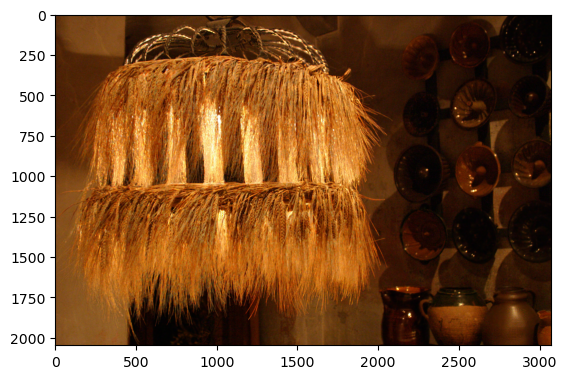

In [9]:
# Mask assisted merge
final_map_blurred_3channel = np.repeat(np.expand_dims(final_map_blurred,2),3, axis=2)
A_final = (1-final_map_blurred_3channel) * A_detail + final_map_blurred_3channel * A_base
plt.imsave('outputs/outputs_report_part1/J_sr_{}_ss_{}_ks_{}_Afinal_ocd.png'.format(sigma_r, sigma_s, kernel_size[0]), np.clip(A_final, 0,1))
plt.imshow(np.clip(A_final, 0,1))

# plt.imsave('outputs/outputs_report_part1/J_sr_{}_ss_{}_ks_{}_eps_{}_Afinal_change_ocd.png'.format(sigma_r, sigma_s, kernel_size[0], eps), np.clip((lamp_amb_norm-A_final)*100, 0,1))
# plt.imshow(np.clip((lamp_amb_norm-A_final)*100, 0,1))

# plt.imsave('outputs/outputs_report_part1/J_sr_{}_ss_{}_ks_{}_Afinal_map_ocd.png'.format(sigma_r, sigma_s, kernel_size[0]), np.clip(final_map_blurred, 0,1))
# plt.imshow(np.clip(final_map_blurred, 0,1))